In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import all CSVs
sales_train_df = pd.read_csv("./dataset/sales_train.csv")
item_cat_df = pd.read_csv("./dataset/item_categories.csv")
item_df = pd.read_csv("./dataset/items.csv")
shops_df = pd.read_csv("./dataset/shops.csv")
test_df = pd.read_csv("./dataset/test.csv")

In [3]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales_train_df.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [5]:
# Convert date object to datetime format
sales_train_df['date'] = pd.to_datetime(sales_train_df['date'], format='%d.%m.%Y')

In [6]:
sales_train_df.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [7]:
monthly_sales_df = sales_train_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'date': ['min', 'max'], 'item_price': 'mean', 'item_cnt_day': 'sum'})

In [8]:
# example usage groupby
#df.groupby('A').agg({'B': ['min', 'max'], 'C': 'sum'})
monthly_sales_df = sales_train_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'date': ['min', 'max'], 'item_price': 'mean', 'item_cnt_day': 'sum'})

In [9]:
monthly_sales_df.tail()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
33             59      22087   2015-10-05 2015-10-23      119.0          6.0
                       22088   2015-10-03 2015-10-27      119.0          2.0
                       22091   2015-10-03 2015-10-03      179.0          1.0
                       22100   2015-10-18 2015-10-18      629.0          1.0
                       22102   2015-10-16 2015-10-16     1250.0          1.0

In [10]:
sales_train_df['revenue'] = sales_train_df['item_price']*sales_train_df['item_cnt_day']

In [11]:
# Check missing values
sales_train_df.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
revenue           0
dtype: int64

In [12]:
monthly_sales_shop_df = sales_train_df.groupby(['date_block_num', 'shop_id']).agg(
    {'revenue': 'sum'})

In [13]:
# Check a store
temp = monthly_sales_shop_df.loc[(slice(0,33), 42), 'revenue']

In [14]:
temp.index.get_level_values('date_block_num')

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
            33],
           dtype='int64', name='date_block_num')

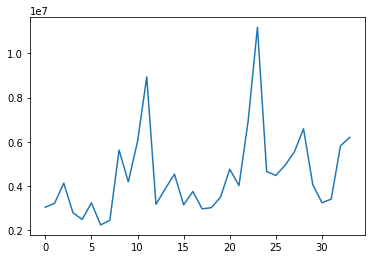

In [15]:
# plot sales by store 42
plt.plot(temp.index.get_level_values('date_block_num'), temp.values)

In [16]:
monthly_sales_total_df = sales_train_df.groupby(['date_block_num']).agg(
    {'revenue': 'sum'})

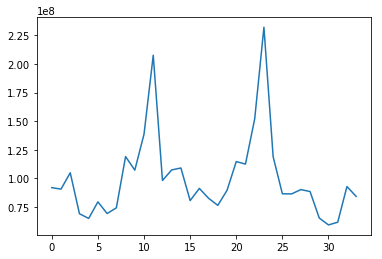

In [17]:
# plot sales for all stores aggregated
plt.plot(monthly_sales_total_df)

In [18]:
# look at items and categories for items
item_count_df = item_df.groupby(['item_category_id'])['item_id'].count()

In [19]:
item_count_df = item_count_df.sort_values()
item_count_df.head()

item_category_id
79    1
10    1
51    1
1     2
50    2
Name: item_id, dtype: int64

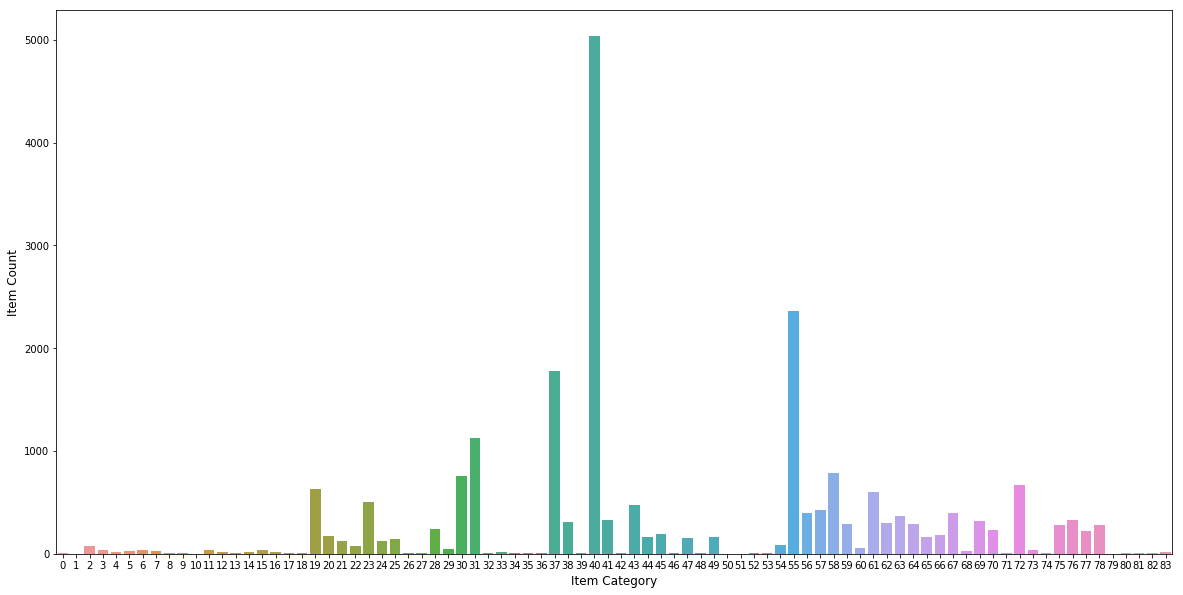

In [20]:
# plot item category and count 
plt.figure(figsize=(20,10))
sns.barplot(item_count_df.index, item_count_df.values)
plt.ylabel('Item Count', fontsize=12)
plt.xlabel('Item Category', fontsize=12)
plt.show()

In [21]:
item_count_df.agg(['min', 'max'])

min       1
max    5035
Name: item_id, dtype: int64

In [22]:
item_count_sorted_df = item_count_df.reset_index()

In [23]:
#item_count_sorted_df.values[:,0]
item_count_sorted_df['item_id'].values
item_count_sorted_df.head()

,item_category_id,item_id
0,79,1
1,10,1
2,51,1
3,1,2
4,50,2


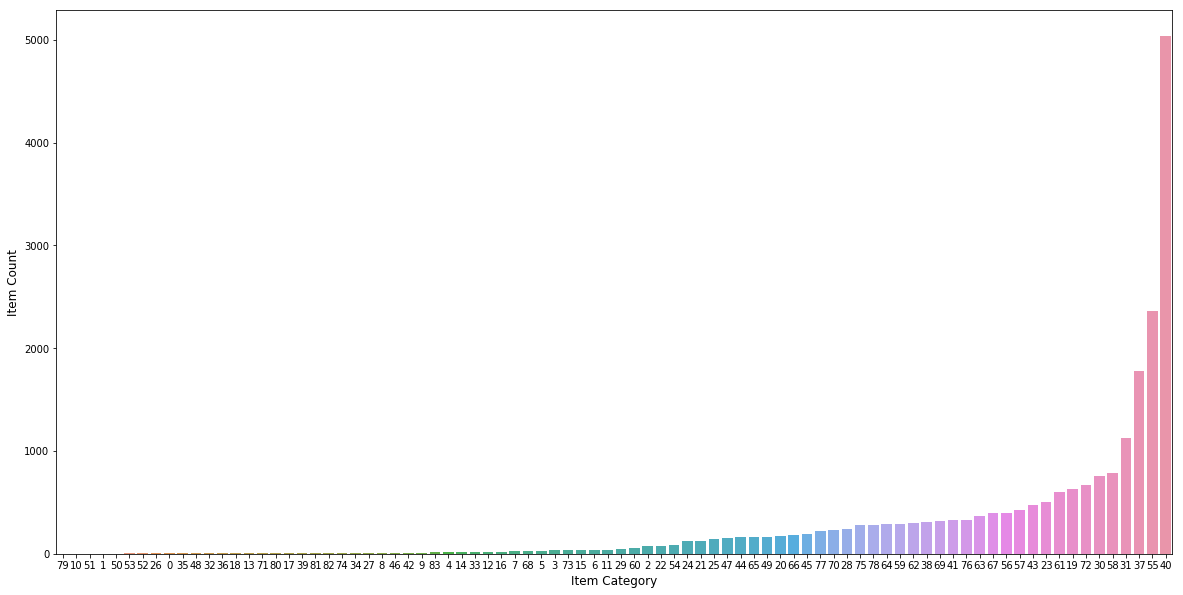

In [24]:
# plot item category and count but order ascending
plt.figure(figsize=(20,10))
#sns.barplot(item_count_sorted_df['item_category_id'], item_count_sorted_df['item_id'], order=item_count_sorted_df['item_id'])
sns.barplot(x=item_count_sorted_df['item_category_id'].values, y=item_count_sorted_df['item_id'].values, order=item_count_sorted_df['item_category_id'].values)
plt.ylabel('Item Count', fontsize=12)
plt.xlabel('Item Category', fontsize=12)
plt.show()

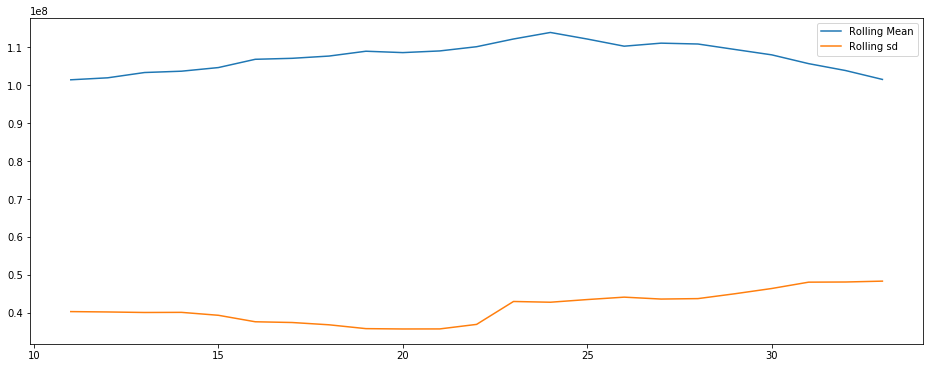

In [25]:
# Look at rolling avg and std dev
plt.figure(figsize=(16,6))
plt.plot(monthly_sales_total_df.rolling(window=12, center=False).mean(),label='Rolling Mean');
plt.plot(monthly_sales_total_df.rolling(window=12, center=False).std(),label='Rolling sd');
plt.legend();

In [26]:
import statsmodels.api as sm

In [29]:
# Look at monthly total sales for all stores
monthly_sales_total_df.head()

,revenue
date_block_num,
0,9.194709e+07
1,9.066571e+07
2,1.049327e+08
3,6.915429e+07
4,6.506531e+07


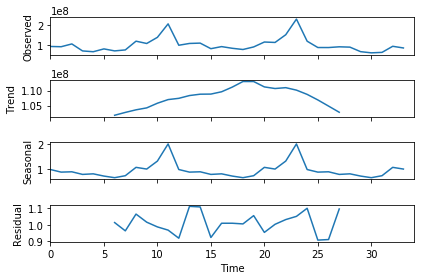

In [27]:
# multiplicative
res = sm.tsa.seasonal_decompose(monthly_sales_total_df.values,freq=12,model="multiplicative")
fig = res.plot()

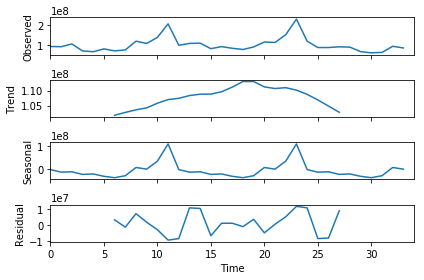

In [28]:
# additive
res = sm.tsa.seasonal_decompose(monthly_sales_total_df.values,freq=12,model="additive")
fig = res.plot()

# Forecast for item_cnt not revenue

In [ ]:
# Kaggle wants to predict item_cnt not revenue...switch to forecast item_cnt
monthly_sales_shop_df = sales_train_df.groupby(['date_block_num', 'shop_id']).agg(
    {'item_cnt_day': 'sum'})

In [32]:
monthly_sales_total_df = sales_train_df.groupby(['date_block_num']).agg(
    {'item_cnt_day': 'sum'})

In [34]:
# Check a store
temp = monthly_sales_shop_df.loc[(slice(0,33), 42), 'item_cnt_day']

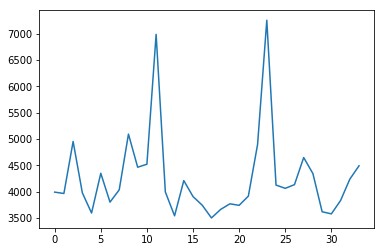

In [35]:
# plot sales by store 42
plt.plot(temp.index.get_level_values('date_block_num'), temp.values)

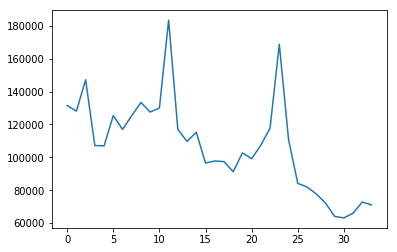

In [36]:
# plot sales for all stores aggregated
plt.plot(monthly_sales_total_df)

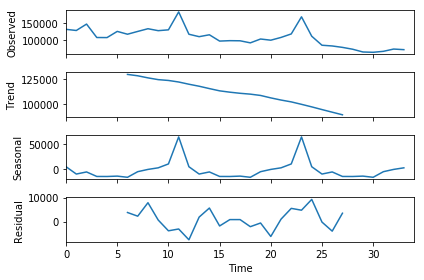

In [37]:
# additive
res = sm.tsa.seasonal_decompose(monthly_sales_total_df.values,freq=12,model="additive")
fig = res.plot()

In [41]:
# Check for staionarity of time series.
X = monthly_sales_total_df['item_cnt_day'].values
result = sm.tsa.adfuller(X)

In [42]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.395704
p-value: 0.142953
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


In [43]:
# try removing trend by differencing, taken form machinelearningmastery.com article
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [44]:
diff_X = difference(X)

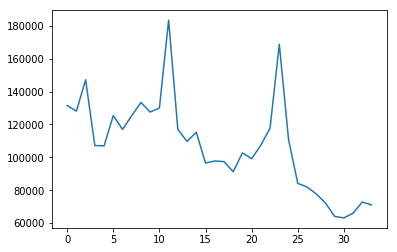

In [46]:
plt.plot(X)

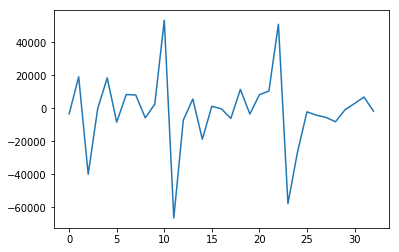

In [45]:
plt.plot(diff_X)

In [49]:
#Remove seasonality
diff_season_X = difference(X, 12) # 12 for yearly

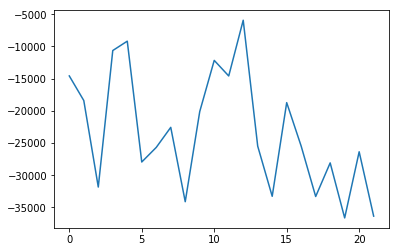

In [50]:
plt.plot(diff_season_X)

In [51]:
result_noseason = sm.tsa.adfuller(diff_season_X)

In [52]:
print('ADF Statistic: %f' % result_noseason[0])
print('p-value: %f' % result_noseason[1])
print('Critical Values:')
for key, value in result_noseason[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.270101
p-value: 0.016269
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646


# ADF tells us with seasonality removed, we can assume stationarity to allow us to use TSA forecasting models.